# Data With Geometry

This notebook demonstrates how we can load the geometry of 
geographical locations when we load the data associated with
them just by adding the `with_geoemetry=True` flag to a call
to `censusdis.data.download`.

This is a nice powerful feature because it saves us the time
of loading data and maps separately and dealing with the 
not-quite-matching column names we have to join them on. 
Setting this one flag saves us all that effort.

## Imports and configuration

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC, STATE_NAMES_FROM_IDS, STATE_GA

## What dataset and variables?

In [3]:
DATASET = "acs/acs5"
YEAR = 2020

In [4]:
# This is a census variable for median household income.
# See https://api.census.gov/data/2020/acs/acs5/variables/B19013_001E.html
MEDIAN_HOUSEHOLD_INCOME_VARIABLE = "B19013_001E"

In [5]:
VARIABLES = ["NAME", MEDIAN_HOUSEHOLD_INCOME_VARIABLE]

In [6]:
MISSING_VALUE = -666666666

## Shapefile reader

In [7]:
reader = cem.ShapeReader(year=YEAR)

In [8]:
gdf_state_bounds = reader.read_cb_shapefile("us", "state")
gdf_state_bounds = gdf_state_bounds[gdf_state_bounds["STATEFP"].isin(ALL_STATES_AND_DC)]

## Function to drop missing values

In [9]:
CENSUS_MISSING_VALUE = -666666666


def drop_missing_mhi(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    return gdf[gdf[MEDIAN_HOUSEHOLD_INCOME_VARIABLE] != CENSUS_MISSING_VALUE]

## Plot function

In [10]:
plt.rcParams["figure.figsize"] = (18, 8)


def plot_map(
    gdf: gpd.GeoDataFrame,
    geo: str,
    *,
    gdf_bounds: Optional[gpd.GeoDataFrame] = None,
    bounds_color: str = "white",
    max_income: float = 200_000.0,
):
    if gdf_bounds is None:
        gdf_bounds = gdf

    ax = cem.plot_us(gdf_bounds, color="lightgray")

    ax = cem.plot_us(
        gdf,
        MEDIAN_HOUSEHOLD_INCOME_VARIABLE,
        cmap="autumn",
        legend=True,
        vmin=0.0,
        vmax=max_income,
        ax=ax,
    )

    ax = cem.plot_us_boundary(gdf_bounds, edgecolor=bounds_color, linewidth=0.5, ax=ax)

    ax.set_title(f"{YEAR} Median Household Income by {geo.title()}")

    ax.axis("off")

## Query with geography

### Region

In [11]:
gdf_region = ced.download(DATASET, YEAR, VARIABLES, region="*", with_geometry=True)

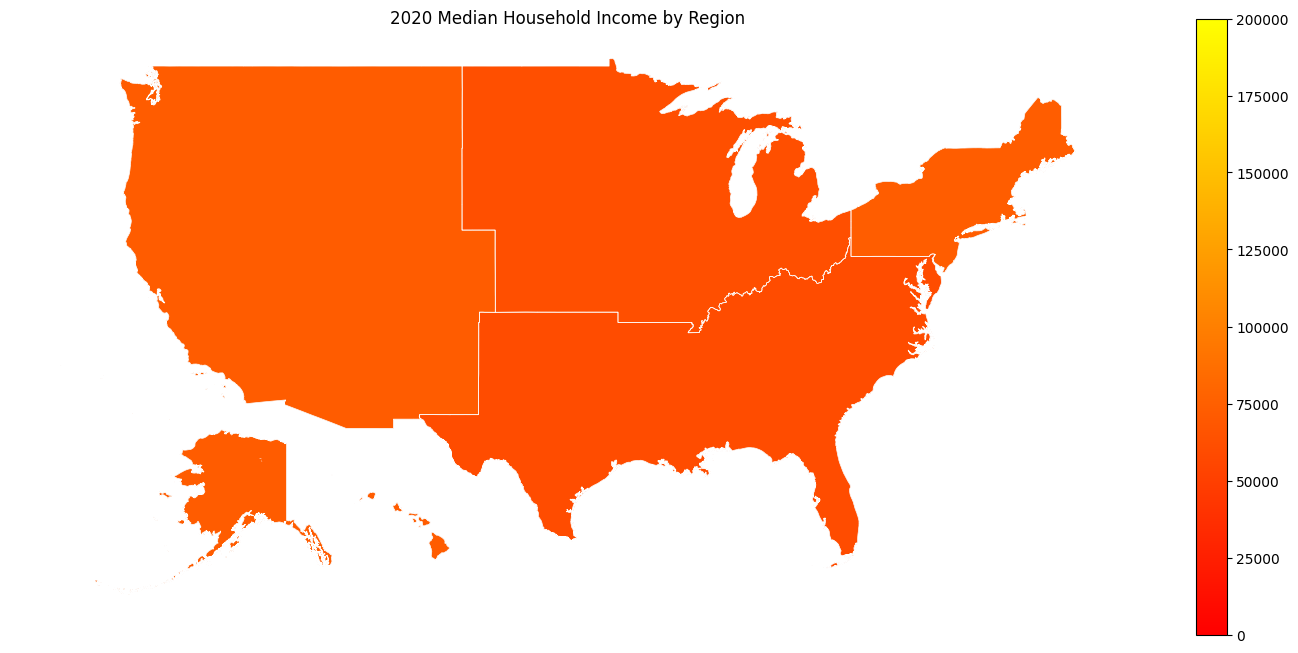

In [12]:
plot_map(gdf_region, "region")

### Division

In [13]:
gdf_division = ced.download(DATASET, YEAR, VARIABLES, division="*", with_geometry=True)

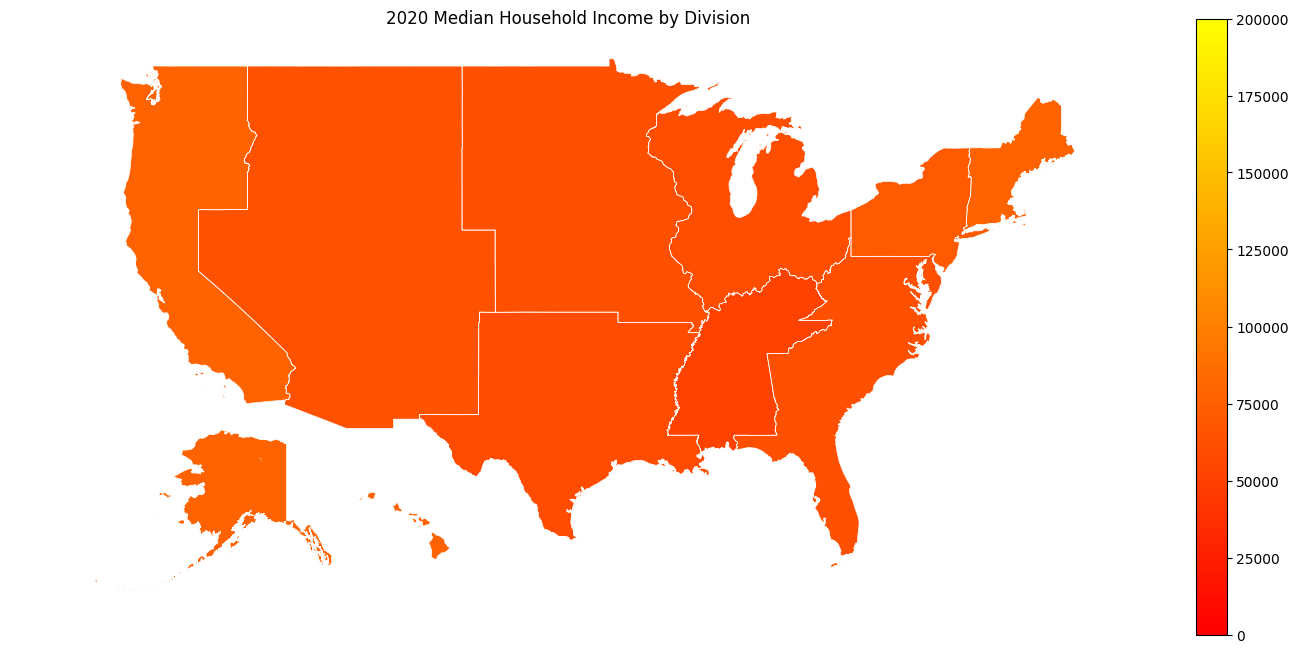

In [14]:
plot_map(gdf_division, "division")

### State

In [15]:
gdf_state = ced.download(DATASET, YEAR, VARIABLES, state="*", with_geometry=True)

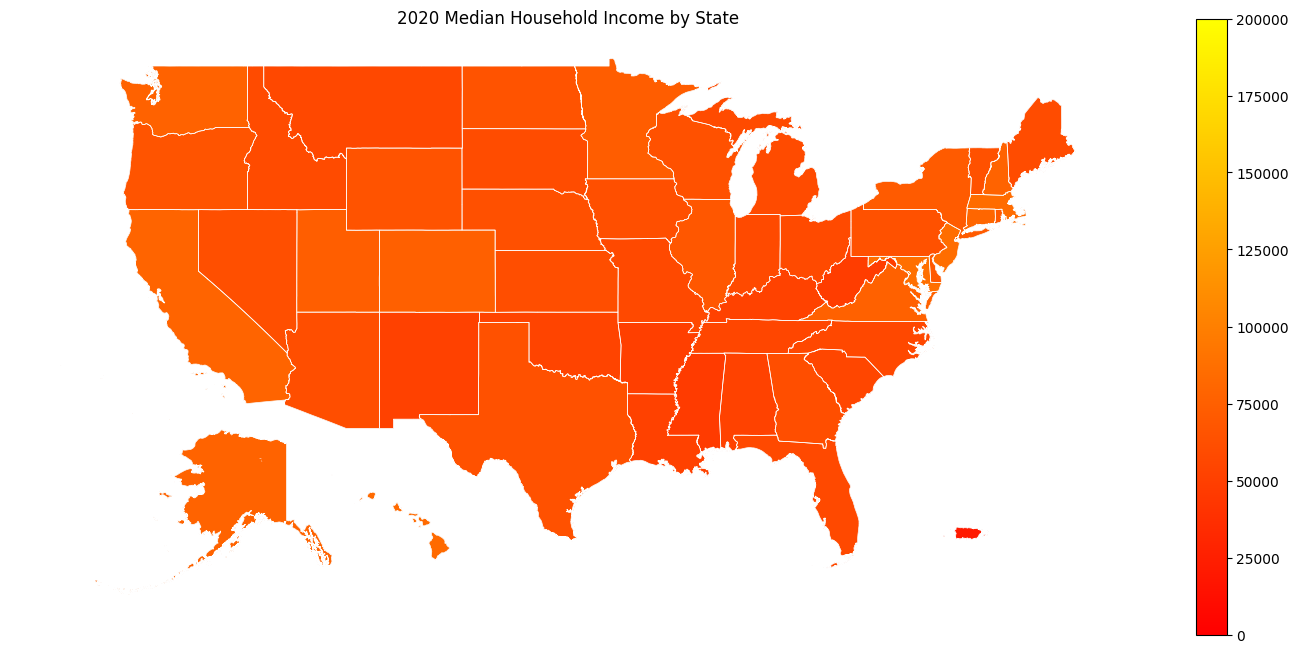

In [16]:
plot_map(gdf_state, "state")

### CBSA

In [17]:
gdf_cbsa = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    metropolitan_statistical_area_micropolitan_statistical_area="*",
    with_geometry=True,
)

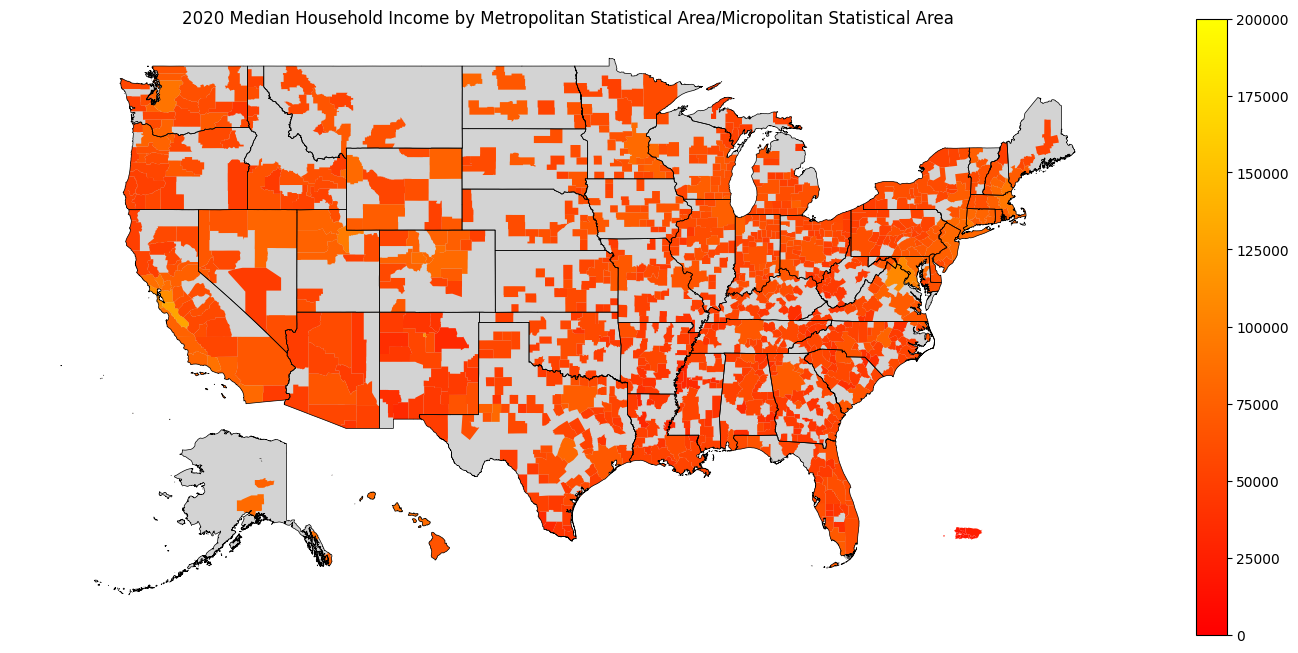

In [18]:
plot_map(
    gdf_cbsa,
    "metropolitan statistical area/micropolitan statistical area",
    gdf_bounds=gdf_state_bounds,
    bounds_color="black",
)

### CSA

In [19]:
gdf_csa = ced.download(
    DATASET, YEAR, VARIABLES, combined_statistical_area="*", with_geometry=True
)

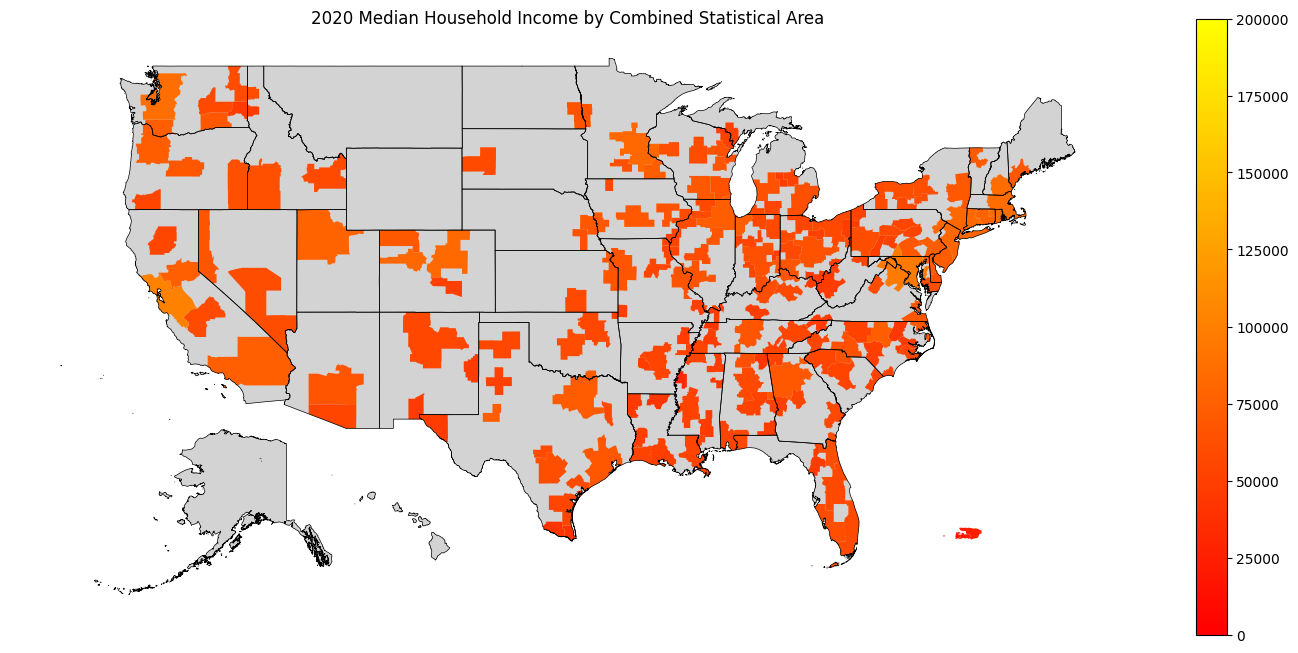

In [20]:
plot_map(
    gdf_csa,
    "combined statistical area",
    gdf_bounds=gdf_state_bounds,
    bounds_color="black",
)

### County

In [21]:
gdf_county = ced.download(
    DATASET, YEAR, VARIABLES, state="*", county="*", with_geometry=True
)

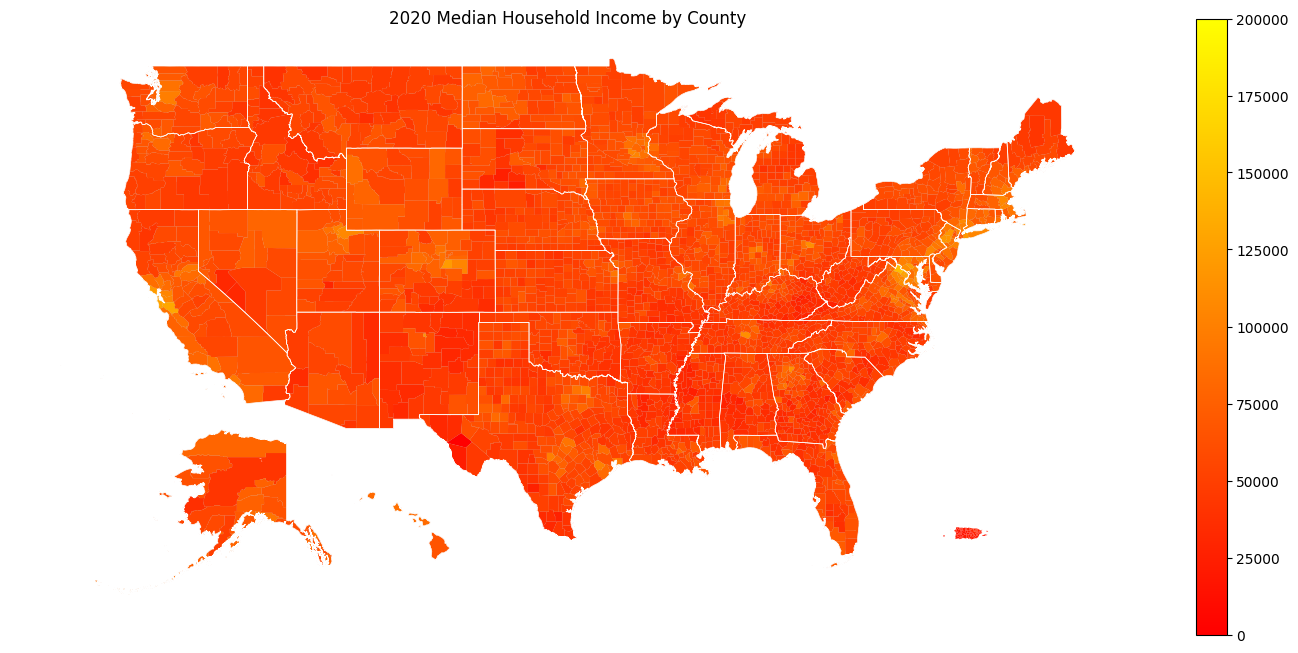

In [22]:
plot_map(gdf_county, "county", gdf_bounds=gdf_state_bounds)

### Census Tract

In [23]:
STATE = STATE_GA

In [24]:
gdf_tract = ced.download(
    DATASET, YEAR, VARIABLES, state=STATE, tract="*", with_geometry=True
)

gdf_tract = drop_missing_mhi(gdf_tract)

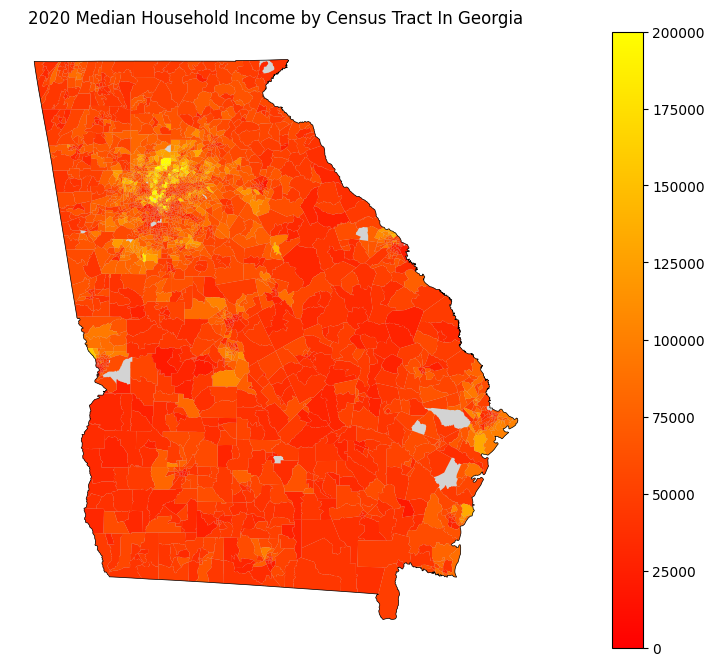

In [25]:
plot_map(
    gdf_tract,
    f"census tract in {STATE_NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

### Block Group

In [26]:
gdf_bg = ced.download(
    DATASET, YEAR, VARIABLES, state=STATE, block_group="*", with_geometry=True
)

In [27]:
gdf_bg = drop_missing_mhi(gdf_bg)

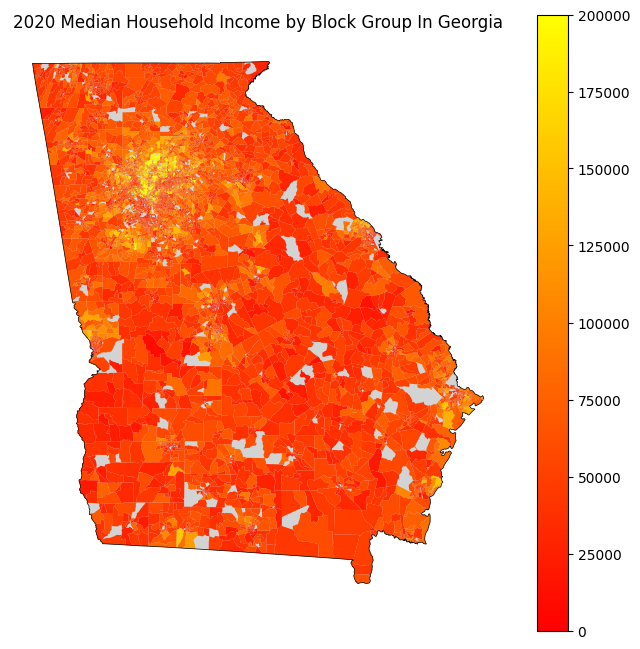

In [28]:
plt.rcParams["figure.figsize"] = (8, 8)

plot_map(
    gdf_bg,
    f"block group in {STATE_NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)